In [1]:
import pandas as pd
import os
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential 
from keras.layers import Dense, Activation

2022-06-15 05:51:50.150205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
result_dir = '../results/ids-dataset'

In [3]:
train_df = pd.read_parquet(os.path.join(result_dir,"cicids2017_traindf.parquet"))
test_df = pd.read_parquet(os.path.join(result_dir,"cicids2017_testdf.parquet"))

In [4]:
from utils import *

In [5]:
train_df_bn = set_binary_label(train_df,label_col='Label', default_class='Benign',return_col=False)
test_df_bn = set_binary_label(test_df,label_col='Label', default_class='Benign',return_col=False)

In [6]:
lab_dic, lab_name = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}


In [7]:
train_mul= set_multiple_label(train_df,label_col='Label', label_dic = lab_dic, return_col=False)
test_mul = set_multiple_label(test_df,label_col='Label', label_dic = lab_dic, return_col=False)

drop Benign
drop Infiltration
drop Heartbleed
original instances:  1040360
drop intances:  751106
after drop:  289254
drop Benign
drop Infiltration
drop Heartbleed
original instances:  260090
drop intances:  187670
after drop:  72420


# binary classification

In [8]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [10]:
st_scaler_bn = StandardScaler()

In [11]:
trainx = train_df_bn.loc[:,train_df.columns!='Label']
trainy = train_df_bn['Label']
testx = test_df_bn.loc[:,test_df.columns!='Label']
testy = test_df_bn['Label']

In [14]:
trainx.shape

(1040360, 67)

In [12]:
trainx_st = st_scaler_bn.fit_transform(trainx)
testx_st = st_scaler_bn.transform(testx)

# Train DNN model for Binary Classification

In [23]:
from keras.models import Sequential 
from keras.layers import Dense, Activation

In [24]:
clf_bn = Sequential([
    Dense(32, input_shape =(67,) ,activation="relu"),
    Dense(1, activation='sigmoid')
])

In [26]:
clf_bn.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
clf_bn.fit(trainx_st,trainy,epochs=20, batch_size=256)

Epoch 1/20
4064/4064 [==============================] - 23s 6ms/step - loss: 0.0862 - accuracy: 0.9627
Epoch 2/20
4064/4064 [==============================] - 22s 6ms/step - loss: 0.0726 - accuracy: 0.9750
Epoch 3/20
4064/4064 [==============================] - 23s 6ms/step - loss: 0.0692 - accuracy: 0.9799
Epoch 4/20
4064/4064 [==============================] - 22s 5ms/step - loss: 0.0674 - accuracy: 0.9841
Epoch 5/20
4064/4064 [==============================] - 22s 5ms/step - loss: 0.0646 - accuracy: 0.9893
Epoch 6/20
4064/4064 [==============================] - 22s 5ms/step - loss: 0.0614 - accuracy: 0.9914
Epoch 7/20
4064/4064 [==============================] - 22s 5ms/step - loss: 0.0580 - accuracy: 0.9924
Epoch 8/20
4064/4064 [==============================] - 23s 6ms/step - loss: 0.0509 - accuracy: 0.9933
Epoch 12/20
4064/4064 [==============================] - 23s 6ms/step - loss: 0.0496 - accuracy: 0.9934
Epoch 13/20
4064/4064 [==============================] - 23s 6ms/step - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
score = clf_bn.evaluate(testx_st,testy, batch_size=256)
print(score)

1016/1016 [==============================] - 4s 4ms/step - loss: 0.0824 - accuracy: 0.9934
[0.08239506185054779, 0.9934407472610474]


## model save

In [78]:
clf_bn.save(os.path.join(result_dir,"cicids2017_nn_binary"))

INFO:tensorflow:Assets written to: ../results/ids-dataset/cicids2017_nn_binary/assets


In [29]:
# lr_clf.score(testx_st, testy)
# 0.9547964166250145

In [32]:
predy.numpy()

array([[4.0944651e-06],
       [1.0000000e+00],
       [3.0096697e-02],
       ...,
       [8.2442765e-24],
       [1.0000000e+00],
       [2.5382647e-37]], dtype=float32)

In [33]:
from sklearn.metrics import roc_curve, auc

predy = clf_bn(testx_st).numpy()
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.values, predy, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

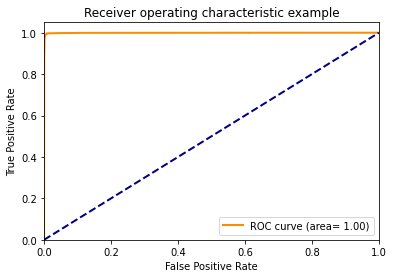

In [34]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# multi-class classification

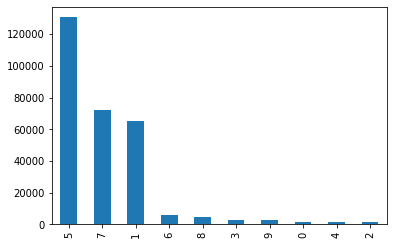

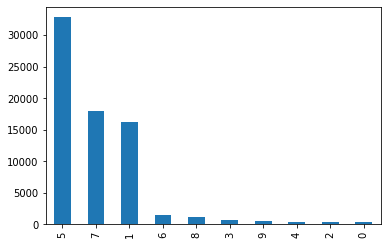

In [8]:
train_mul['Label'].value_counts().plot(kind='bar')
plt.show()
test_mul['Label'].value_counts().plot(kind='bar')
plt.show()

In [8]:
trainx_m = train_mul.loc[:,train_mul.columns!='Label']
trainy_m = train_mul['Label']
testx_m = test_mul.loc[:,test_mul.columns!='Label']
testy_m = test_mul['Label']

In [9]:
num_class = len(np.unique(testy_m))

In [10]:
st_scaler_mul = StandardScaler()

In [11]:
trainx_m_st = st_scaler_mul.fit_transform(trainx_m)
testx_m_st = st_scaler_mul.transform(testx_m)

In [12]:
from keras.utils import to_categorical

In [13]:
trainy_mc = to_categorical(trainy_m)
testy_mc = to_categorical(testy_m)

In [1]:
clf_mul = Sequential([
    Dense(32, input_shape =(67,) ,activation="relu"),
    Dense(num_class, activation='softmax')
])

In [15]:
from tensorflow.keras import losses
loss_fn = losses.CategoricalCrossentropy(label_smoothing=0.09)

In [16]:
clf_mul.compile(optimizer="rmsprop", loss=loss_fn, metrics=['accuracy'])
clf_mul.fit(trainx_m_st,trainy_mc,epochs=20, batch_size=256)

Epoch 1/20
  34/1130 [..............................] - ETA: 5s - loss: 1.4478 - accuracy: 0.7183

2022-06-15 05:52:03.033813: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1130/1130 [==============================] - 7s 5ms/step - loss: 0.5399 - accuracy: 0.9771
Epoch 2/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4742 - accuracy: 0.9959
Epoch 3/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4723 - accuracy: 0.9970
Epoch 4/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4714 - accuracy: 0.9976
Epoch 5/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4708 - accuracy: 0.9982
Epoch 6/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4703 - accuracy: 0.9985
Epoch 7/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4702 - accuracy: 0.9987
Epoch 8/20
1130/1130 [==============================] - 5s 5ms/step - loss: 0.4702 - accuracy: 0.9987
Epoch 9/20
1130/1130 [==============================] - 5s 5ms/step - loss: 0.4699 - accuracy: 0.9987
Epoch 10/20
1130/1130 [==============================] - 6s 5ms/step - loss: 0.4693 - accurac

In [17]:
score_m = clf_mul.evaluate(testx_m_st,testy_mc, batch_size=256)
print(score_m)

283/283 [==============================] - 1s 4ms/step - loss: 0.4692 - accuracy: 0.9990
[0.46921873092651367, 0.9989643692970276]


## model save

In [18]:
clf_mul.save(os.path.join(result_dir,"cicids2017_nn_mult_LS"))

INFO:tensorflow:Assets written to: ../results/ids-dataset/cicids2017_nn_mult_LS/assets


In [27]:
clf_mul17 = keras.models.load_model(os.path.join(result_dir,"cicids2017_nn_mult"))
# clf_mul17_LS = keras.models.load_model(os.path.join(result_dir,"cicids2017_nn_mult_LS"))

In [47]:
clf_mul.predict(testx_m_st)

2264/2264 [==============================] - 2s 786us/step


array([[1.25529739e-20, 1.33731443e-10, 3.17639430e-37, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.27417985e-21, 9.16151048e-16, 1.95654193e-34, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.94646599e-11, 9.60154197e-17, 6.31389385e-11, ...,
        1.00000000e+00, 1.28442679e-08, 4.32760672e-09],
       ...,
       [6.34147310e-15, 7.24045503e-06, 4.58907259e-08, ...,
        9.99992728e-01, 2.44009279e-09, 1.64337688e-09],
       [1.35369782e-14, 3.83661489e-17, 3.13073097e-18, ...,
        3.09970383e-10, 9.99998331e-01, 1.69053726e-06],
       [4.21196937e-24, 1.00000000e+00, 1.68402506e-30, ...,
        0.00000000e+00, 0.00000000e+00, 1.09677095e-35]], dtype=float32)

In [73]:
def apply_nn_clf_with_scaler(clf, scaler, df_x, prob=True):
    df_x_st = scaler.transform(df_x)
    preds = clf.predict(df_x_st)
    if prob:
        return preds
    else:        
        if preds.shape[1]==1:
            return np.argmax(preds>0.5).astype("int32")
        else:
            return np.argmax(preds, axis=-1)
def score_nn_clf_with_scaler(clf, scaler, df_x, df_y, binary=True):
    df_x_st = scaler.transform(df_x)
    if binary:
        y = df_y.values
    else:
        y = to_categorical(df_y.values)
    score = clf.evaluate(df_x_st.values,y, batch_size=256)
    return score

# evaluate multi-class model

In [50]:
from sklearn.metrics import confusion_matrix

In [23]:
pred_m = clf_mul.predict(testx_m_st)
predy_m = np.argmax(pred_m,axis=-1)

2264/2264 [==============================] - 2s 1ms/step


In [63]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
confusion_mtx = confusion_matrix(testy_m, predy_m)

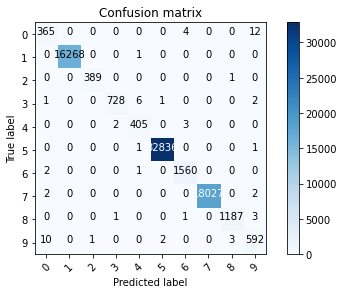

In [65]:
plot_confusion_matrix(confusion_mtx, classes = range(10))

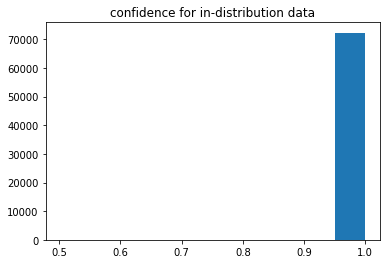

In [67]:
plt.hist(np.max(pred_m,axis=1))
plt.title("confidence for in-distribution data")
plt.show()

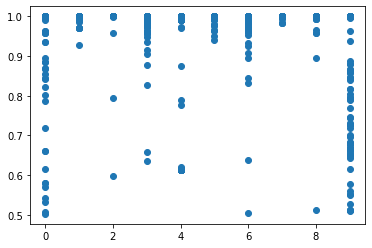

In [69]:
plt.scatter(predy_m,np.max(pred_m,axis=1))
plt.show()

In [19]:
ooc_col = 'Benign' # 'SSH-Patator', 'Heartbleed', 'Benign', 'Infiltration'
ooc_idx = (train_df['Label']==ooc_col)
train_ooc = train_df.loc[ooc_idx]
train_ooc = train_ooc.loc[:,train_ooc.columns!='Label']

In [20]:
train_ooc.shape

(751077, 67)

In [24]:
lab_dic17, lab_name17 = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}


In [28]:
pred_ooc = apply_nn_clf_with_scaler(clf_mul17, st_scaler_mul, train_ooc[:1000], prob = False)
prob_ooc = apply_nn_clf_with_scaler(clf_mul17, st_scaler_mul, train_ooc[:1000], prob = True)

32/32 [==============================] - 0s 1ms/step


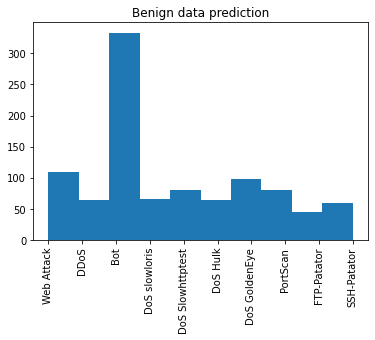

In [29]:
plt.hist(pred_ooc)
plt.title("Benign data prediction")
plt.xticks(range(10),lab_name17, rotation=90)
plt.show()

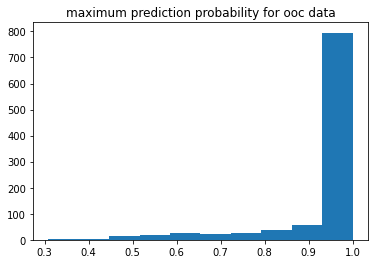

In [30]:
plt.hist(np.max(prob_ooc,axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()

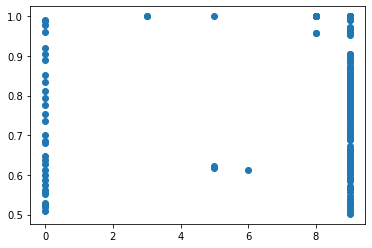

In [77]:
plt.scatter(pred_ooc,np.max(prob_ooc,axis=1),)
plt.show()